In [30]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import warnings
warnings.filterwarnings("ignore")

In [2]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

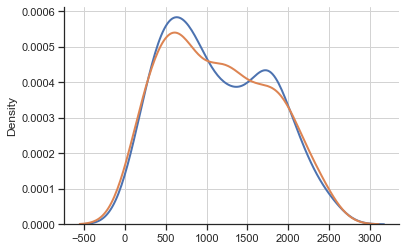

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

<Axes: ylabel='Density'>

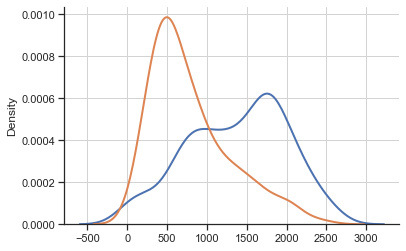

In [4]:
sns.kdeplot(y_tr[np.where(y_tr["cens"] == 0)[0]]["time"], label="train")
sns.kdeplot(y_tr[np.where(y_tr["cens"] == 1)[0]]["time"], label="train")

(0.0, 4000.0)

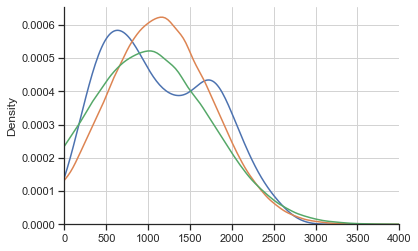

In [129]:
import scipy.stats as stats
from scipy.optimize import root

class TruncNorm:
    _ctor_param = {"name": "TruncNorm"}
    @staticmethod
    def fit(y):
        mu_e = np.mean(y)
        sigma_e = np.std(y)
        def equations(l_var):
            mu, sigma = l_var
            alpha = -mu/sigma
            phi_a = 1/np.sqrt(2*np.pi) * np.exp(-1/2*(alpha**2))
            Z = 1 - stats.norm.cdf(alpha)
            eq1 = mu + phi_a * sigma / Z - mu_e
            eq2 = (sigma**2) * (1 + alpha*phi_a/Z - (phi_a/(Z**2))**2) - sigma_e**2
            return [eq1, eq2]
        
        solution = root(equations, [mu_e, sigma_e])
#         print("Solution:", solution.x)
        return solution.x
    def rvs(mu, sigma, size, random_state=42):
        return stats.norm.rvs(mu, sigma, size=size, random_state=random_state)
    
    def valid(y):
        mu_e = np.mean(y)
        sigma_e = np.std(y)
        
        params = TruncNorm.fit(y)
        a = TruncNorm.rvs(*params, size=100000, random_state=42)
        a = a[a > 0]
        print(mu_e, np.mean(a))
        print(sigma_e, np.std(a))
        

sns.kdeplot(y_tr["time"])
for st in [stats.norm, TruncNorm, 
#            stats.lognorm, stats.gamma, stats.laplace, stats.laplace_asymmetric, 
#            stats.rayleigh, stats.weibull_min, stats.genlogistic
          ]:
    params = st.fit(y_tr["time"])
    sns.kdeplot(st.rvs(*params, size=100000, random_state=42))
plt.xlim((0, 4000))

In [130]:
TruncNorm.valid(y_tr["time"])

1123.7755991285403 1124.4256075820297
639.4141379734477 644.4378898293105


### Informative censuring comparison

In [131]:
from survivors.external.nonparametric import KaplanMeier

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

SF IBS:0.19145, AUPRC:0.58663
SF1 IBS:0.17690, AUPRC:0.64792
SF2 IBS:0.17500, AUPRC:0.68467


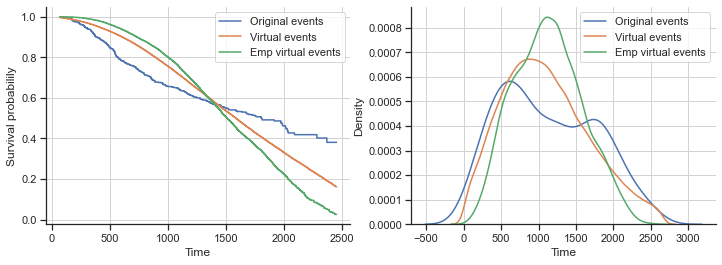

In [132]:
def med_std(x):
    N = len(x)
    d2 = abs(x - np.median(x))**2  # abs is for complex `a`
    var = np.sum(d2) / N  # note use of `ddof`
    return var**0.5

class KaplanMeierZeroAfter(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.array(durations)
        self.events = np.array(right_censor)
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfterTh(KaplanMeier):
    def __init__(self, d_type, *args, **kwargs):
        self.d_type = d_type
        super().__init__(*args, **kwargs)
        
    def fit(self, durations, right_censor, weights=None):
#         q1, q2 = np.quantile(durations, [0.05, 0.95])
        params = self.d_type.fit(durations)
#         params = self.d_type.fit(durations[right_censor == 1])
#         params = list(params)
#         params[1] = params[1] / np.sqrt(1.5)
        self.durs = self.d_type.rvs(*params, size=100000, random_state=42)
        self.events = np.random.choice(right_censor, size=100000, replace=True)
#         self.durs = np.hstack([durations.copy(), self.durs])
#         self.events = np.hstack([right_censor.copy(), self.events])

        ind = (self.durs >= durations.min()) & (self.durs <= durations.max())
#         ind = (self.durs >= q1) & (self.durs <= q2)
        self.events = self.events[ind]
        self.durs = self.durs[ind]
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfterEmp(KaplanMeierZeroAfter):
    """
    Nonparametric model with virtual events generated by bootstrap meaning
    """
    def __init__(self, n=2, *args, **kwargs):
        self.n = n
        super().__init__(*args, **kwargs)
        
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.random.choice(durations, size=(self.n, 20000), replace=True).mean(axis=0)
        self.events = np.random.choice(right_censor, size=20000, replace=True)
        
        super().fit(self.durs, self.events)

y_ = y
X_ = X

km = KaplanMeierZeroAfter()
km.fit(y_["time"], y_["cens"])
sf = km.survival_function_at_times(bins_HO)

km1 = KaplanMeierZeroAfterTh(stats.lognorm)
km1.fit(y_["time"], y_["cens"])
sf1 = km1.survival_function_at_times(bins_HO)

km2 = KaplanMeierZeroAfterEmp(2)
km2.fit(y_["time"], y_["cens"])
sf2 = km2.survival_function_at_times(bins_HO)

ibs_sf = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
ibs_sf1 = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
ibs_sf2 = metr.ibs_remain(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

auprc_sf = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
auprc_sf1 = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
auprc_sf2 = metr.auprc(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].step(bins_HO, sf, label="Original events")
axes[0].step(bins_HO, sf1, label="Virtual events")
axes[0].step(bins_HO, sf2, label="Emp virtual events")
axes[0].legend()

sns.kdeplot(km.durs, ax=axes[1], label="Original events")
sns.kdeplot(km1.durs, ax=axes[1], label="Virtual events")
sns.kdeplot(km2.durs, ax=axes[1], label="Emp virtual events")
axes[1].legend()

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Survival probabilily")
axes[1].set_xlabel("Time")
print(f"SF IBS:{ibs_sf:.5f}, AUPRC:{auprc_sf:.5f}")
print(f"SF1 IBS:{ibs_sf1:.5f}, AUPRC:{auprc_sf1:.5f}")
print(f"SF2 IBS:{ibs_sf2:.5f}, AUPRC:{auprc_sf2:.5f}")

In [133]:
np.quantile(km.durs, np.linspace(0.01, 0.99, 20))

array([  40.05      ,  238.54473684,  351.53947368,  454.06842105,
        540.17631579,  597.01578947,  713.67894737,  772.        ,
        865.50263158,  972.83421053, 1113.16578947, 1222.        ,
       1351.82894737, 1486.64210526, 1641.49210526, 1730.        ,
       1842.62105263, 1982.46052632, 2155.45526316, 2467.6       ])

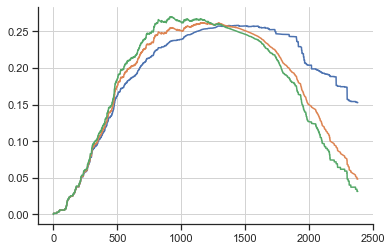

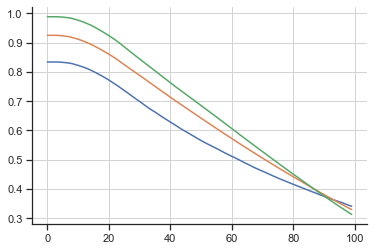

In [134]:
ibs_sf_ = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
ibs_sf1_ = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
ibs_sf2_ = metr.ibs_remain(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)

plt.plot(ibs_sf_)
plt.plot(ibs_sf1_)
plt.plot(ibs_sf2_)
plt.show()

auprc_sf_ = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
auprc_sf1_ = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
auprc_sf2_ = metr.auprc(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
plt.plot(auprc_sf_)
plt.plot(auprc_sf1_)
plt.plot(auprc_sf2_)
plt.show()

<Axes: >

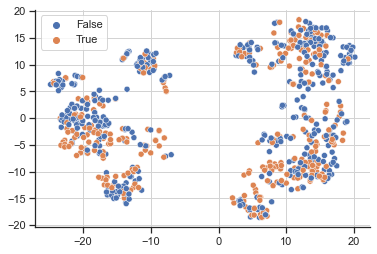

In [135]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X.fillna(X.median()))
X_embedded = TSNE(n_components=2, perplexity=50, learning_rate='auto', random_state=42).fit_transform(X_scaled)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=y["cens"])

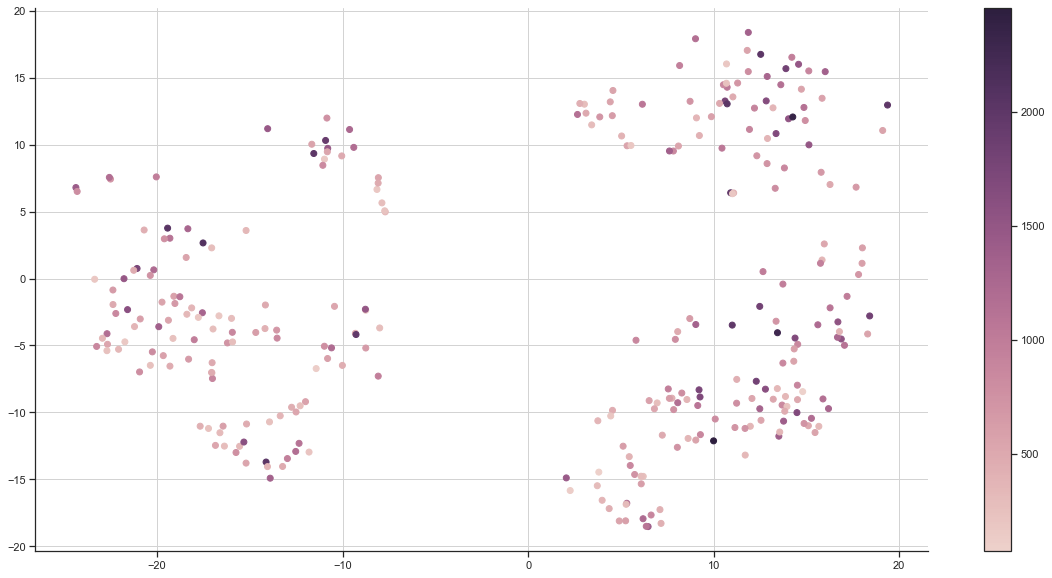

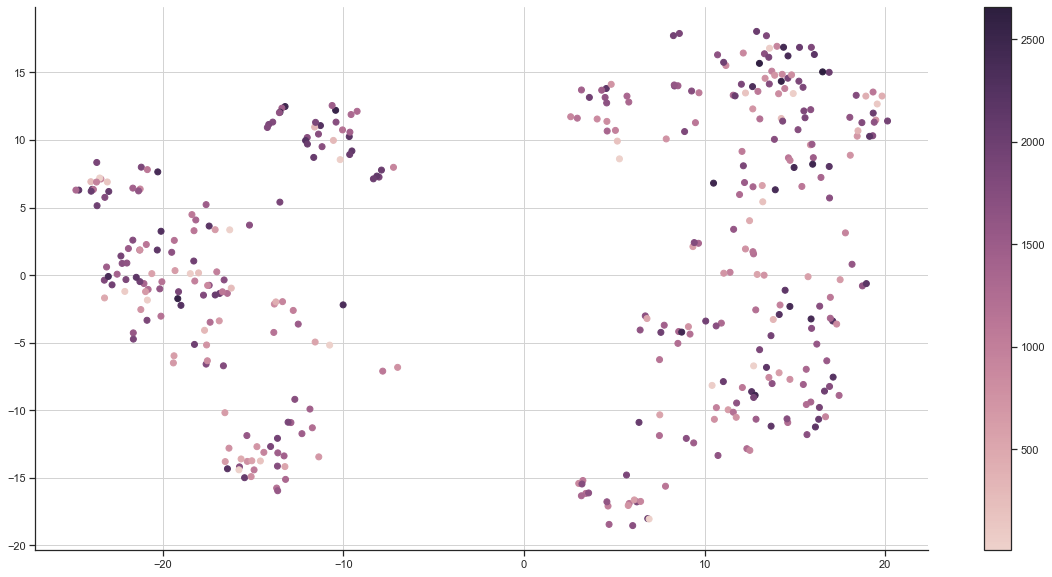

In [136]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(20, 10))
ind = np.where(y["cens"] == 1)[0]
points = ax.scatter(x=X_embedded[ind, 0], y=X_embedded[ind, 1],
                c=y[ind]["time"], cmap=cmap)
f.colorbar(points)

f, ax = plt.subplots(figsize=(20, 10))
ind = np.where(y["cens"] == 0)[0]
points = ax.scatter(x=X_embedded[ind, 0], y=X_embedded[ind, 1],
                c=y[ind]["time"], cmap=cmap)
f.colorbar(points)

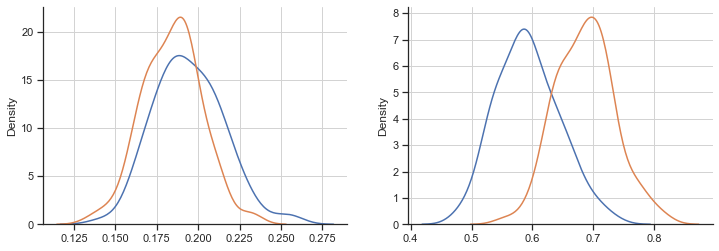

0.1944&0.1843&3.096e-04
0.5926&0.6865&2.403e-29


Text(0, 0.5, '$AUPRC$')

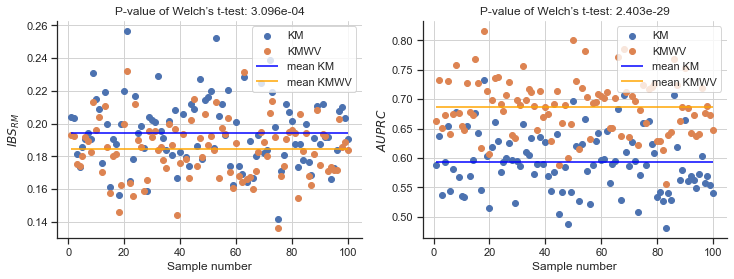

In [137]:
x = np.linspace(1, 100, 100)
ibs_1 = []
ibs_2 = []
auprc_1 = []
auprc_2 = []
np.random.seed(1)

for i, _ in enumerate(x):
    x_sub = df.sample(n=int(X.shape[0]*0.05), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
    time = x_sub["time"].to_numpy()
    cens = x_sub["cens"].to_numpy()
    
    bins_ = cnt.get_bins(time=time)
    y_v = cnt.get_y(cens=cens, time=time)
    
    km = KaplanMeierZeroAfter()
    km.fit(y_v["time"], y_v["cens"])
    sf = km.survival_function_at_times(bins_)

    km1 = KaplanMeierZeroAfterTh(stats.norm)
    km1.fit(y_v["time"], y_v["cens"])
    sf1 = km1.survival_function_at_times(bins_)

    ibs_1.append(metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    ibs_2.append(metr.ibs_remain(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

    auprc_1.append(metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    auprc_2.append(metr.auprc(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(ibs_1, ax=axes[0])
sns.kdeplot(ibs_2, ax=axes[0])

sns.kdeplot(auprc_1, ax=axes[1])
sns.kdeplot(auprc_2, ax=axes[1])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(x, ibs_1, label="KM")
axes[0].scatter(x, ibs_2, label="KMWV")
axes[0].hlines([np.mean(ibs_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[0].hlines([np.mean(ibs_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[0].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
axes[0].legend()
axes[0].set_xlabel("Sample number")
axes[0].set_ylabel(r"$IBS_{RM}$")
print(f"{np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")

axes[1].scatter(x, auprc_1, label="KM")
axes[1].scatter(x, auprc_2, label="KMWV")
axes[1].hlines([np.mean(auprc_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[1].hlines([np.mean(auprc_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[1].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
print(f"{np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
axes[1].legend()

axes[1].set_xlabel("Sample number")
axes[1].set_ylabel(r"$AUPRC$")

In [138]:
from survivors.tree import CRAID

def split_by_tree(X, y, categ=[]):
    p = {'balance': None, 'categ': categ, 'criterion': 'peto', 'cut': False, 'depth': 5, 
         'leaf_model': 'base', 'min_samples_leaf': 0.02, 'signif': 0.05, 'woe': True}

    tree = CRAID(**p)
    tree.fit(X, y)
    return tree.predict(X, target="numb")
    

def print_metric_by_nonparam(df, subsample=0.3, prefix="", tree=False, categ=[]):
    ibs_1 = []
    ibs_2 = []
    auprc_1 = []
    auprc_2 = []
    np.random.seed(1)
    
    d = {}
    for i in range(int(1/subsample*5)):
        x_sub = df.sample(n=int(df.shape[0]*subsample), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
        time = x_sub["time"].to_numpy()
        cens = x_sub["cens"].to_numpy()

        bins_ = cnt.get_bins(time=time)
        y_src = cnt.get_y(cens=cens, time=time)
        
        strats = [y_src]
        
#         if tree:
#             X_ = x_sub[[c for c in x_sub.columns if not(c in ["time", "cens"])]]
#             nodes = split_by_tree(X_, y_src, categ=categ)
#             strats = [y_src[np.where(nodes == n)[0]] for n in set(nodes)]
#         print(len(strats))
        for y_v in strats:
            for th in ["", 2, 4, 6, stats.norm, TruncNorm, stats.lognorm, stats.gamma, stats.laplace, 
                       stats.laplace_asymmetric, stats.rayleigh, stats.weibull_min, stats.genlogistic]:
                if th == "":
                    suff = "km"
                    km = KaplanMeierZeroAfter()
                elif isinstance(th, int):
                    suff = f"Emp({th})"
                    km = KaplanMeierZeroAfterEmp(th)
                else:
                    suff = th._ctor_param["name"]
                    km = KaplanMeierZeroAfterTh(th)
                km.fit(y_v["time"], y_v["cens"])
                sf = km.survival_function_at_times(bins_)

                ibs_ = metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_)
                auprc_ = metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_)
                if suff+"IBS" in d:
                    d[suff+"IBS"].append(ibs_)
                else:
                    d[suff+"IBS"] = [ibs_]
                if suff+"AUPRC" in d:
                    d[suff+"AUPRC"].append(auprc_)
                else:
                    d[suff+"AUPRC"] = [auprc_]
    
    d_ = {k: np.mean(v) for k, v in d.items()}
    d_["dataset"] = prefix
    d_["subsample"] = subsample
    return d_

#     print(f"{prefix + '|'}IBS:({subsample}): {np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
#     print(f"{prefix + '|'}AUPRC({subsample}): {np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")

In [ ]:
from survivors.datasets import DATASETS_LOAD

l = []
for ds_name in ["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2"]:
    X, y, features, categ, sch_nan = DATASETS_LOAD[ds_name]()
    bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

    df = X.copy()
    df["time"] = y["time"]
    df["cens"] = y["cens"]
    
    for subsample in [1, 0.7, 0.5, 0.3, 0.1, 0.05]:
        d = print_metric_by_nonparam(df, subsample=subsample, prefix=ds_name, tree=True)
        l.append(d)
        print(d)
#     d = print_metric_by_nonparam(df, subsample=0.3, prefix=ds_name)
#     print(d)
#     l.append(d)
#     d = print_metric_by_nonparam(df, subsample=0.05, prefix=ds_name)
#     print(d)
#     l.append(d)
    
df_res = pd.DataFrame(l).T

{'kmIBS': 0.1845759382639201, 'kmAUPRC': 0.5896996848462435, 'Emp(2)IBS': 0.15811729873118996, 'Emp(2)AUPRC': 0.6883094383779976, 'Emp(4)IBS': 0.16432110471943825, 'Emp(4)AUPRC': 0.699022690681313, 'Emp(6)IBS': 0.17127967074751588, 'Emp(6)AUPRC': 0.700998351989563, 'normIBS': 0.16513360442620498, 'normAUPRC': 0.6791131393128613, 'TruncNormIBS': 0.16222836266654855, 'TruncNormAUPRC': 0.6661167331570729, 'lognormIBS': 0.160246225827597, 'lognormAUPRC': 0.6713122716233902, 'gammaIBS': 0.15952669546777484, 'gammaAUPRC': 0.6686125636560547, 'laplaceIBS': 0.1611188702261106, 'laplaceAUPRC': 0.677581152188106, 'laplace_asymmetricIBS': 0.15641569582692855, 'laplace_asymmetricAUPRC': 0.6608060318303066, 'rayleighIBS': 0.16102671335090885, 'rayleighAUPRC': 0.6705094793225448, 'weibull_minIBS': 0.16052331795297278, 'weibull_minAUPRC': 0.6691507617579632, 'genlogisticIBS': 0.15913690072013348, 'genlogisticAUPRC': 0.66917120476636, 'dataset': 'GBSG', 'subsample': 1}
{'kmIBS': 0.18252654528396256, '

{'kmIBS': 0.19641123752608342, 'kmAUPRC': 0.6035392354494513, 'Emp(2)IBS': 0.17042935191370287, 'Emp(2)AUPRC': 0.6995326105221195, 'Emp(4)IBS': 0.17445782489818004, 'Emp(4)AUPRC': 0.7123514209235837, 'Emp(6)IBS': 0.18115751425057386, 'Emp(6)AUPRC': 0.7149086616030043, 'normIBS': 0.17960449348193525, 'normAUPRC': 0.6964169077767184, 'TruncNormIBS': 0.17755164299202714, 'TruncNormAUPRC': 0.6828380267039491, 'lognormIBS': 0.1741903038581231, 'lognormAUPRC': 0.6869137486372605, 'gammaIBS': 0.17408867942214082, 'gammaAUPRC': 0.6848065782203079, 'laplaceIBS': 0.1720330896414103, 'laplaceAUPRC': 0.6920223550573734, 'laplace_asymmetricIBS': 0.1724723673812525, 'laplace_asymmetricAUPRC': 0.6868712427787906, 'rayleighIBS': 0.17550544615840818, 'rayleighAUPRC': 0.6863956513610815, 'weibull_minIBS': 0.1746282313029589, 'weibull_minAUPRC': 0.6832946881294041, 'genlogisticIBS': 0.17333325498476398, 'genlogisticAUPRC': 0.6851175536282839, 'dataset': 'PBC', 'subsample': 0.3}
{'kmIBS': 0.20227219045754

{'kmIBS': 0.16756347215445774, 'kmAUPRC': 0.5937528486346834, 'Emp(2)IBS': 0.12699156884503068, 'Emp(2)AUPRC': 0.6947480381182612, 'Emp(4)IBS': 0.12962926880923417, 'Emp(4)AUPRC': 0.7054962723804512, 'Emp(6)IBS': 0.13417482485787718, 'Emp(6)AUPRC': 0.7083911646583636, 'normIBS': 0.13528093058038548, 'normAUPRC': 0.680912344715215, 'TruncNormIBS': 0.1351429179602836, 'TruncNormAUPRC': 0.6727626447234808, 'lognormIBS': 0.13584930828554637, 'lognormAUPRC': 0.6778951633802899, 'gammaIBS': 0.13565776455017298, 'gammaAUPRC': 0.6780933667997964, 'laplaceIBS': 0.14053030120570015, 'laplaceAUPRC': 0.6841069648247654, 'laplace_asymmetricIBS': 0.13957901730414418, 'laplace_asymmetricAUPRC': 0.6865265931477813, 'rayleighIBS': 0.13643509543058235, 'rayleighAUPRC': 0.6676487304693716, 'weibull_minIBS': 0.13486119557944606, 'weibull_minAUPRC': 0.6748495013082978, 'genlogisticIBS': 0.13805200007155033, 'genlogisticAUPRC': 0.675930598283116, 'dataset': 'rott2', 'subsample': 1}
{'kmIBS': 0.1660753501050

{'kmIBS': 0.2045336161083286, 'kmAUPRC': 0.845903136405605, 'Emp(2)IBS': 0.1565672957180207, 'Emp(2)AUPRC': 0.887202960939505, 'Emp(4)IBS': 0.14274893513949205, 'Emp(4)AUPRC': 0.8861117937814608, 'Emp(6)IBS': 0.15365483201067198, 'Emp(6)AUPRC': 0.882669539627208, 'normIBS': 0.1775084496424482, 'normAUPRC': 0.8903543077258245, 'TruncNormIBS': 0.18488979996197807, 'TruncNormAUPRC': 0.8878020343411761, 'lognormIBS': 0.1755021001102088, 'lognormAUPRC': 0.880518522060733, 'gammaIBS': 0.17571320110810837, 'gammaAUPRC': 0.874959980781707, 'laplaceIBS': 0.17342460742914775, 'laplaceAUPRC': 0.8858292343264149, 'laplace_asymmetricIBS': 0.17566200510369562, 'laplace_asymmetricAUPRC': 0.8657655433559968, 'rayleighIBS': 0.17636209573982303, 'rayleighAUPRC': 0.8859106615217905, 'weibull_minIBS': 0.17598629313654618, 'weibull_minAUPRC': 0.8779972112677549, 'genlogisticIBS': 0.1756348523050526, 'genlogisticAUPRC': 0.8829181405192081, 'dataset': 'smarto', 'subsample': 0.3}
{'kmIBS': 0.20111997593738054

In [126]:
# df_res.to_csv("./ResultsTable.csv")

In [68]:
df_

,kmIBS,kmAUPRC,Emp(2)IBS,Emp(2)AUPRC,Emp(4)IBS,Emp(4)AUPRC,Emp(6)IBS,Emp(6)AUPRC,normIBS,normAUPRC,...,laplace_asymmetricIBS,laplace_asymmetricAUPRC,rayleighIBS,rayleighAUPRC,weibull_minIBS,weibull_minAUPRC,genlogisticIBS,genlogisticAUPRC,dataset,subsample
30,0.172552,0.281452,0.173533,0.338633,0.186832,0.348762,0.19425,0.351407,0.204542,0.362278,...,0.168626,0.333862,0.194725,0.357455,0.162879,0.314924,0.181108,0.348184,support2,1.0
31,0.173347,0.281961,0.174765,0.340349,0.187865,0.350204,0.195877,0.353208,0.205284,0.363801,...,0.169512,0.335023,0.195696,0.359016,0.162287,0.315037,0.181949,0.349502,support2,0.7
32,0.173005,0.281483,0.174253,0.339355,0.187295,0.349254,0.195126,0.352328,0.205206,0.362992,...,0.169202,0.33454,0.195387,0.358173,0.163805,0.319533,0.181745,0.348919,support2,0.5
33,0.172007,0.282286,0.172748,0.340266,0.185858,0.350353,0.193516,0.353211,0.203496,0.363731,...,0.167762,0.335431,0.19373,0.358952,0.163115,0.32076,0.180091,0.349672,support2,0.3
34,0.172695,0.283079,0.17296,0.341451,0.18594,0.351362,0.193839,0.354423,0.20329,0.364919,...,0.167893,0.336111,0.193654,0.36004,0.162803,0.319448,0.180213,0.350682,support2,0.1
35,0.172573,0.283134,0.173451,0.34016,0.186603,0.349928,0.194508,0.352738,0.204167,0.363267,...,0.168418,0.335074,0.194457,0.3585,0.161542,0.314417,0.180837,0.349294,support2,0.05


GBSG


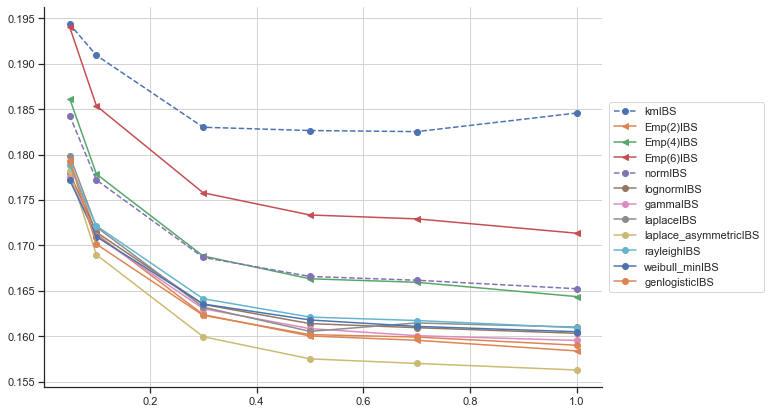

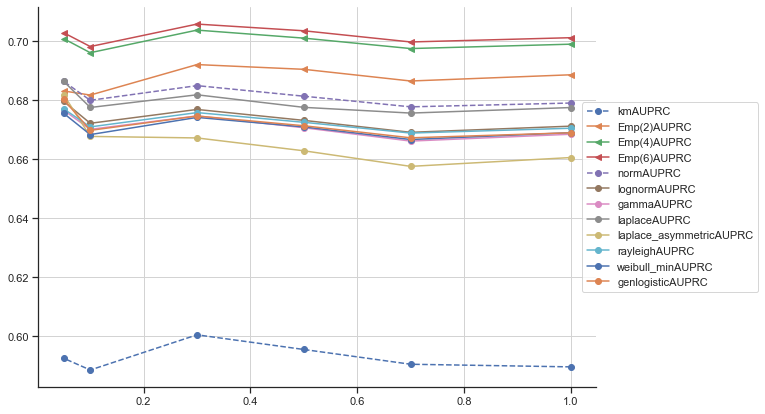

PBC


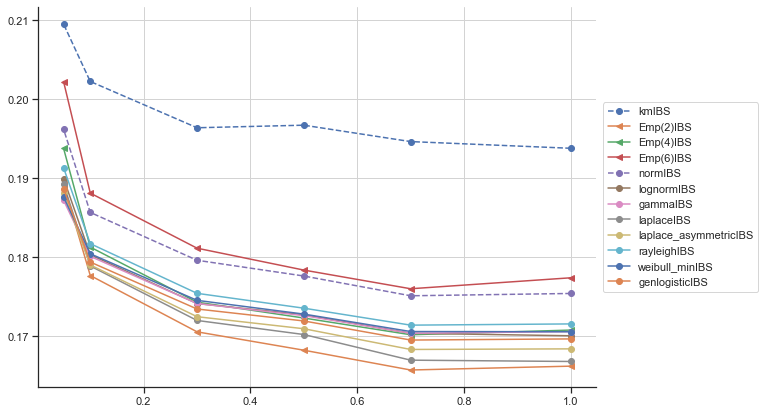

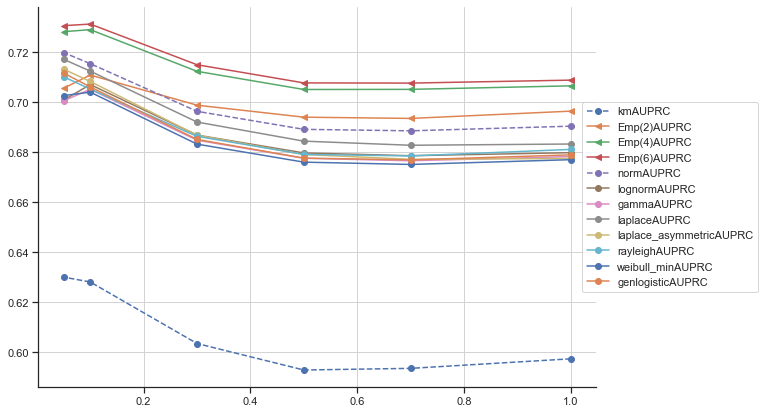

WUHAN


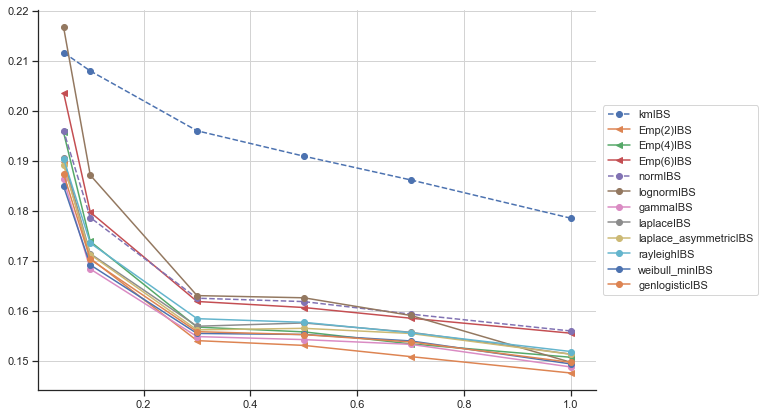

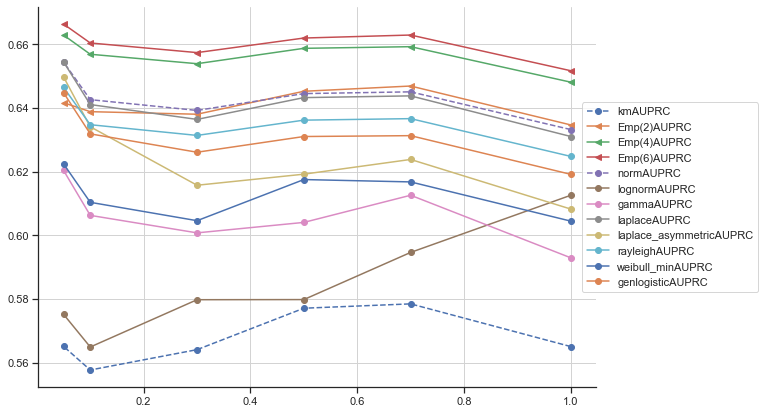

rott2


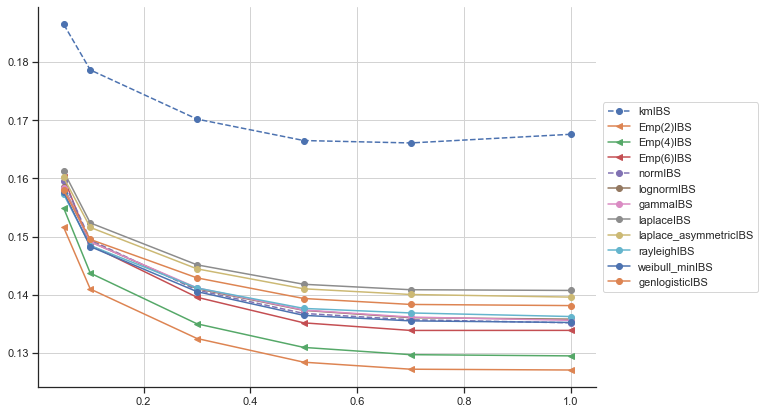

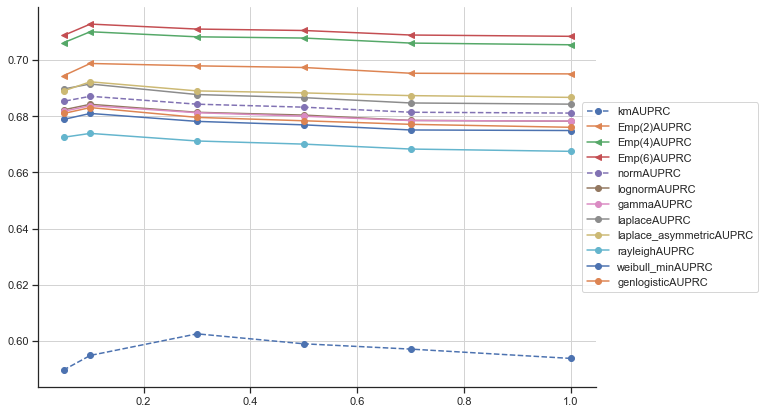

smarto


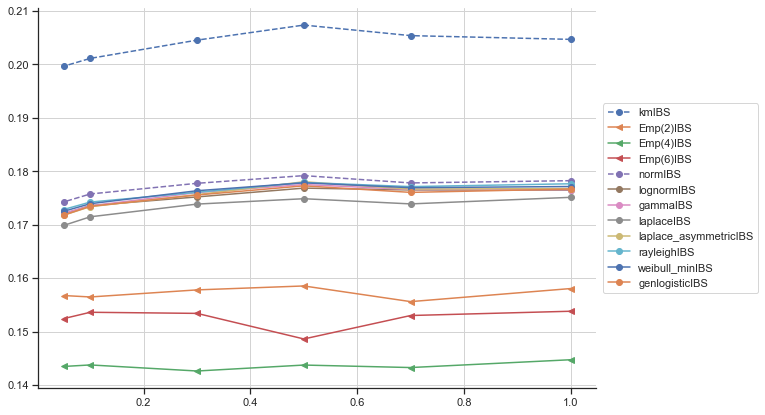

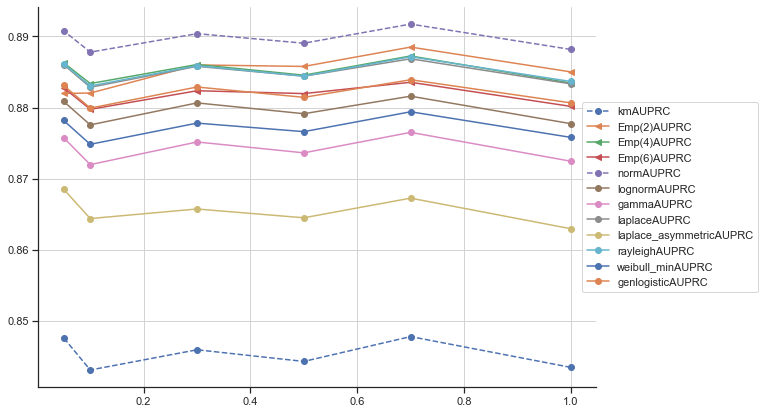

support2


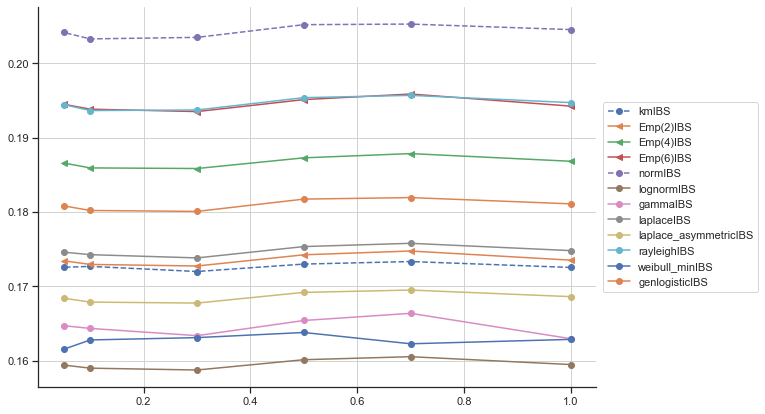

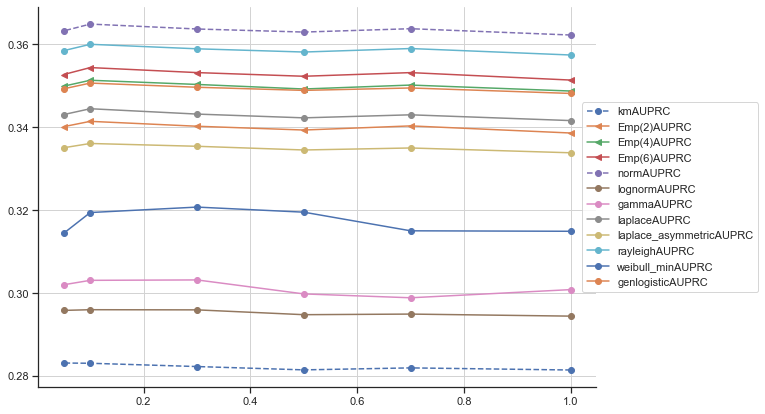

In [94]:
for ds_name in ["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2"]:
    print(ds_name)
    plt.subplots(figsize=(10, 7))
    for c in df_res.T.columns[:-2:2]:
        df_ = df_res.T
        df_ = df_[df_["dataset"] == ds_name]
        ls = '--' if (("km" in c) or ("norm" in c[:4])) else '-'
        plt.plot(df_["subsample"], df_[c], label=c, marker="<" if "Emp" in c else "o", linestyle=ls)
#         plt.plot(df_["subsample"], 1 - df_[c] / df_["kmIBS"], label=c)
    #plt.legend()
    plt.legend(loc="center right", bbox_to_anchor=(1.3, 0.5))
    plt.show()

    plt.subplots(figsize=(10, 7))
    for c in df_res.T.columns[1:-2:2]:
        df_ = df_res.T
        df_ = df_[df_["dataset"] == ds_name]
        ls = '--' if (("km" in c) or ("norm" in c[:4])) else '-'
        plt.plot(df_["subsample"], df_[c], label=c, marker="<" if "Emp" in c else "o", linestyle=ls)
#         plt.plot(df_["subsample"], df_[c] / df_["kmAUPRC"] - 1, label=c)
    #plt.legend()
    plt.legend(loc="center right", bbox_to_anchor=(1.3, 0.5))
    plt.show()

In [102]:
print(df_res.iloc[:-2:2].rank().mean(axis=1).sort_values())
print(df_res.iloc[1:-2:2].rank(ascending=False).mean(axis=1).sort_values())

for g in df_res.loc["dataset"].unique():
    print("="*10, g, "="*10)
    g_sample = (df_res.T[df_res.T["dataset"] == g]).T
    print(g_sample.iloc[:-2:2].rank().mean(axis=1).sort_values())
    print(g_sample.iloc[1:-2:2].rank(ascending=False).mean(axis=1).sort_values())

Emp(2)IBS                 2.861111
gammaIBS                  4.638889
weibull_minIBS            4.916667
laplace_asymmetricIBS     5.166667
genlogisticIBS            5.527778
Emp(4)IBS                 5.750000
lognormIBS                5.777778
laplaceIBS                6.388889
Emp(6)IBS                 8.083333
rayleighIBS               8.361111
normIBS                   9.722222
kmIBS                    10.805556
dtype: float64
Emp(6)AUPRC                 2.277778
Emp(4)AUPRC                 2.444444
normAUPRC                   3.194444
Emp(2)AUPRC                 4.222222
laplaceAUPRC                4.916667
rayleighAUPRC               6.194444
genlogisticAUPRC            7.277778
laplace_asymmetricAUPRC     8.027778
lognormAUPRC                8.333333
gammaAUPRC                  9.555556
weibull_minAUPRC            9.555556
kmAUPRC                    12.000000
dtype: float64
========== GBSG ==========
laplace_asymmetricIBS     1.500000
Emp(2)IBS                 3.333333
genlogist

In [62]:
df_ibs_rank = df_res.iloc[:-2:2].rank()
df_ibs_rank.index = df_ibs_rank.index.str[:-3]

df_auprc_rank = df_res.iloc[1:-2:2].rank(ascending=False)
df_auprc_rank.index = df_auprc_rank.index.str[:-5]

print(pd.concat([df_ibs_rank, df_auprc_rank], axis=1).mean(axis=1).sort_values())

Emp(2)                 3.541667
Emp(4)                 4.097222
Emp(6)                 5.180556
laplace                5.652778
genlogistic            6.402778
norm                   6.458333
laplace_asymmetric     6.597222
lognorm                7.055556
gamma                  7.097222
weibull_min            7.236111
rayleigh               7.277778
km                    11.402778
dtype: float64


In [104]:
# IBS growth
1 - df_res.iloc[:-2:2] / df_res.iloc[[0]].values

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
kmIBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Emp(2)IBS,0.141866,0.1258,0.123774,0.112667,0.102956,0.077362,0.14241,0.148651,0.144891,0.131631,...,0.235357,0.228425,0.221913,0.214807,-0.005688,-0.00818,-0.007213,-0.004306,-0.001534,-0.005085
Emp(4)IBS,0.109466,0.090844,0.089317,0.077439,0.068415,0.042207,0.118837,0.125702,0.124174,0.11248,...,0.306717,0.302613,0.285134,0.281282,-0.082759,-0.083748,-0.082594,-0.080526,-0.076698,-0.081299
Emp(6)IBS,0.071694,0.0526,0.050872,0.039421,0.029106,0.00169,0.084649,0.095773,0.093298,0.077682,...,0.283168,0.249913,0.236152,0.236452,-0.125748,-0.129972,-0.127862,-0.125047,-0.122441,-0.127106
normIBS,0.10478,0.089599,0.087912,0.078243,0.071848,0.051811,0.094899,0.100346,0.097117,0.085468,...,0.135821,0.130942,0.126116,0.127159,-0.185391,-0.184238,-0.186127,-0.183068,-0.177165,-0.183073
lognormIBS,0.13136,0.118212,0.116327,0.106495,0.101947,0.084439,0.122558,0.124739,0.122053,0.11339,...,0.147083,0.143392,0.136944,0.138351,0.075682,0.073829,0.074344,0.077017,0.079258,0.0762
gammaIBS,0.13561,0.123018,0.119352,0.109122,0.104155,0.086394,0.119835,0.124734,0.122639,0.113352,...,0.143846,0.139426,0.137174,0.137748,0.055532,0.040179,0.043853,0.050164,0.048317,0.045486
laplaceIBS,0.127651,0.115349,0.120994,0.108184,0.098897,0.074543,0.13936,0.142251,0.134792,0.124288,...,0.156661,0.149949,0.147348,0.149162,-0.013129,-0.014146,-0.013607,-0.01063,-0.009132,-0.011831
laplace_asymmetricIBS,0.153229,0.139766,0.137563,0.125952,0.11495,0.083399,0.131107,0.135282,0.131068,0.121868,...,0.141364,0.14131,0.137912,0.139541,0.022754,0.022125,0.021986,0.024681,0.027803,0.024081
rayleighIBS,0.128058,0.113882,0.112401,0.103117,0.098252,0.07974,0.114805,0.119458,0.117829,0.106796,...,0.142012,0.139181,0.133652,0.13421,-0.128499,-0.128928,-0.12937,-0.126291,-0.121368,-0.12681


In [103]:
# AUPRC growth
df_res.iloc[1:-2:2] / df_res.iloc[[1]].values - 1

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
kmAUPRC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Emp(2)AUPRC,0.167823,0.162501,0.159382,0.152463,0.158252,0.152808,0.165832,0.168438,0.170578,0.157993,...,0.049175,0.047391,0.046234,0.04056,0.203167,0.20708,0.205595,0.205397,0.206204,0.201408
Emp(4)AUPRC,0.185405,0.181114,0.177124,0.171913,0.182636,0.182717,0.18278,0.18802,0.189255,0.180425,...,0.04772,0.047462,0.047815,0.045668,0.239155,0.242031,0.240762,0.24113,0.241218,0.235907
Emp(6)AUPRC,0.18913,0.184897,0.181308,0.175313,0.186178,0.186109,0.186611,0.192249,0.193702,0.184794,...,0.044651,0.043098,0.043513,0.041529,0.248553,0.252685,0.251682,0.251255,0.252028,0.245833
normAUPRC,0.151589,0.147676,0.144087,0.140582,0.155236,0.158312,0.155771,0.160082,0.162368,0.153918,...,0.053046,0.052594,0.053061,0.050975,0.287176,0.290253,0.289569,0.288522,0.289106,0.28302
lognormAUPRC,0.138309,0.133061,0.13034,0.127152,0.142004,0.146883,0.138038,0.143312,0.14645,0.138172,...,0.041296,0.041073,0.040919,0.039242,0.046182,0.04605,0.047301,0.048447,0.045645,0.044849
gammaAUPRC,0.133661,0.12803,0.126136,0.123497,0.138519,0.141845,0.135439,0.139902,0.142832,0.134769,...,0.034773,0.034574,0.034283,0.033221,0.068923,0.060002,0.065112,0.074035,0.070685,0.066682
laplaceAUPRC,0.148994,0.144101,0.137743,0.135418,0.151106,0.15831,0.143827,0.150348,0.154397,0.146807,...,0.047551,0.047159,0.047193,0.045354,0.213826,0.216573,0.21603,0.215795,0.216954,0.211713
laplace_asymmetricAUPRC,0.120272,0.113526,0.113035,0.111073,0.134455,0.150723,0.134151,0.140901,0.145394,0.138072,...,0.023947,0.023423,0.025282,0.024678,0.186213,0.188191,0.188489,0.188269,0.18734,0.183444
rayleighAUPRC,0.13711,0.132633,0.129243,0.125372,0.139921,0.142623,0.140204,0.14318,0.145438,0.13733,...,0.047553,0.047253,0.047415,0.045476,0.270042,0.273284,0.27245,0.271592,0.271872,0.266181
